# 9 - TSP using Genetic algorithm

## Importing Modules

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from itertools import combinations

## Graph Generation and Display

In [2]:
def generate_random_weighted_graph(n,low,high):
    g = nx.generators.complete_graph(n)
    # add random weights to the graph
    g.add_weighted_edges_from([(a,b,np.random.randint(low,high)) for a,b in g.edges()])
    # creare layout fro plotting and set pos as attribute
    nx.set_node_attributes(g,nx.spring_layout(g),"pos") 
    return g

def plot_graph(g,title="",highlight_edges=[]):
    pos = nx.get_node_attributes(g,"pos")
    plt.figure(figsize=(17,17))
    plt.title(title)
    nx.draw(g,pos=pos,labels = {x:x for x in g.nodes},width=2)
    weights = nx.get_edge_attributes(g,"weight")
    # draw labels for edges
    nx.draw_networkx_edge_labels(g,pos,edge_labels=weights,label_pos=.4);
    
    # highlight highlighted_edges
    nx.draw_networkx_edges(g,pos,edgelist = highlight_edges,edge_color="r",width=3)
    # highlight labels of highlighted edges
    nx.draw_networkx_edge_labels(
        g,pos,
        edge_labels={
            e:w 
            for e,w in weights.items() 
            if e in map(lambda x:tuple(sorted(x)),highlight_edges)
        },
        font_color="r",
        label_pos=.4
    )
    plt.show()

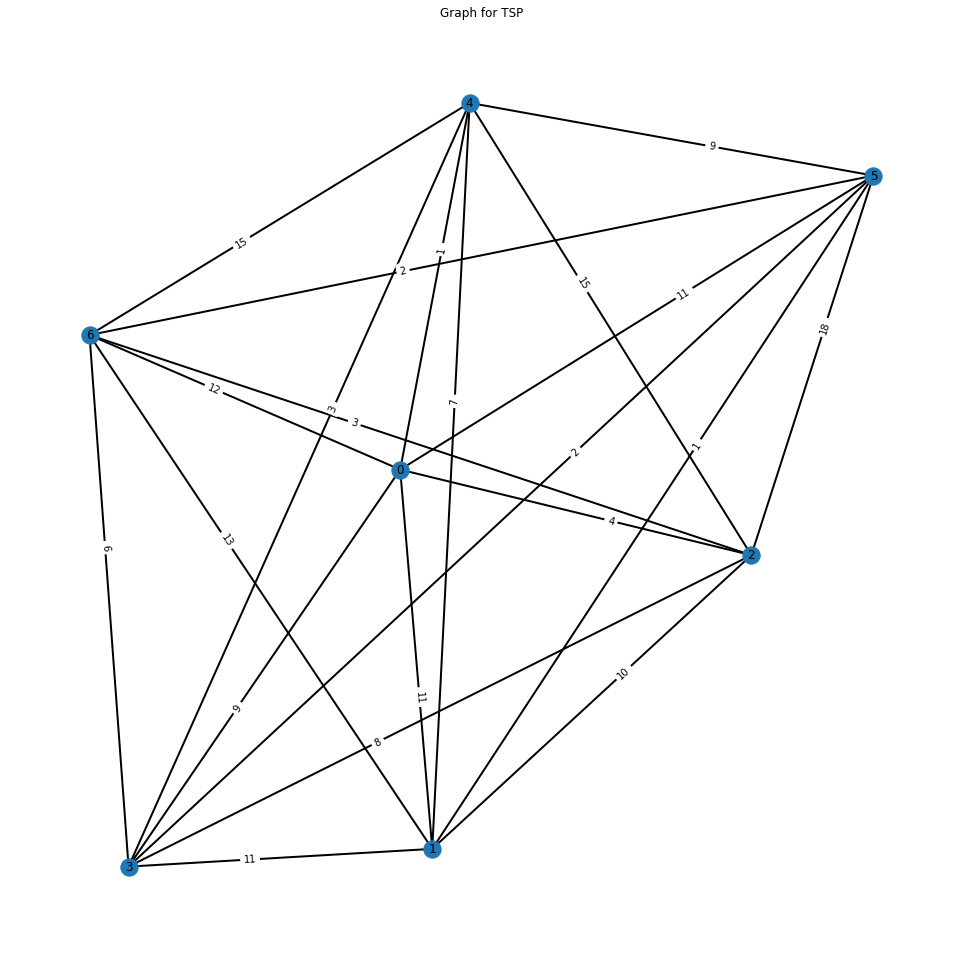

In [3]:
np.random.seed(3)
g = generate_random_weighted_graph(7,1,20)
plot_graph(g,"Graph for TSP")

## Initialization

### Helper function for stochastic initialization

In [4]:
def select_stochastic(a,key,inverse=True):
    a = list(a)
    probs = np.array(list(map(key,a)))
    if inverse:
        probs = 1/np.array(probs)
    probs = probs/probs.sum()
    return type(a[0])(a[np.random.choice(len(a),p=probs)])

### Nearest Neighbour initialization

In [5]:
def nearest_neighbour_initialization(g,method = "greedy", closed_tour=False):
    curr_node = np.random.choice(g.nodes) 
    path = [curr_node]
    not_visited = set(g.nodes)-{curr_node}
    while not_visited:
        not_visited_neighbours = not_visited&set(g.neighbors(curr_node))
        key =lambda x: g[curr_node][x]["weight"]
        if method=="greedy":
            curr_node = min(not_visited_neighbours,key = key) 
        elif method == "stochastic":
            curr_node = select_stochastic(not_visited_neighbours,key = key, inverse= True)
        path.append(curr_node)
        not_visited.remove(curr_node)
    
    # closing the loop if necessary
    if closed_tour:
        path.append(path[0])
    return path



#### [Optional] Testing Nearest Neighbour initialization

In [6]:
np.random.seed(1)
print(nearest_neighbour_initialization(g,method="greedy"))
print(nearest_neighbour_initialization(g,method="greedy",closed_tour=True))
print(nearest_neighbour_initialization(g,method="stochastic"))
print(nearest_neighbour_initialization(g,method="stochastic",closed_tour=True))

[5, 1, 4, 0, 2, 6, 3]
[3, 5, 1, 4, 0, 2, 6, 3]
[4, 5, 1, 6, 2, 0, 3]
[4, 0, 2, 5, 3, 1, 6, 4]


### Shortest Edge Initialization

In [7]:
from collections import defaultdict

In [8]:
def has_cycle(g):
    try:
        nx.find_cycle(g)
    except nx.NetworkXNoCycle:
        return False
    return True

def get_path_from_edges(edges,closed_tour=False):
    path_graph = nx.Graph(edges)
    # if it is an open tour start from a node with a single degree
    curr = min(path_graph.nodes,key=path_graph.degree) 
    path,visited = [curr],{curr}
    while len(path)<len(path_graph):
        curr = (set(path_graph.neighbors(curr))-visited).pop()
        visited.add(curr)
        path.append(curr)
    if closed_tour:
        path.append(path[0])
    return path

In [9]:
def shortest_edge_initialization(g,method="greedy", closed_tour = False):
    edge_list = set(g.edges)
    times_visited  = defaultdict(int)
    tour = set() 
    max_tour_len = len(g) if closed_tour else len(g)-1
    key = nx.get_edge_attributes(g,"weight").get
    while len(tour)<max_tour_len:
        if method == "greedy":
            # Note: this produces same result every time as there is no randomness
            u,v = min(edge_list, key=key)
        elif method == "stochastic":
            u,v = select_stochastic(edge_list,key=key,inverse=True)
        
        times_visited[u]+=1
        times_visited[v]+=1
        tour.add((u,v))
        
        # removing edges that not satisfying the conditions
        edge_list.remove((u,v))

        for u,v in set(edge_list):
            if (
                # closed loop condition 
                (has_cycle(nx.Graph(tour|{(u,v)})) and len(tour) != len(g)-1) 
                # not more than two edges condition
                or times_visited[u] ==2 or times_visited[v] ==2

            ):
                edge_list.remove((u,v))

    return get_path_from_edges(tour,closed_tour=closed_tour)

#### [Optional] Testing Shortest Edge initialization

In [10]:
np.random.seed(1)
print(shortest_edge_initialization(g,method="greedy"))
print(shortest_edge_initialization(g,method="greedy",closed_tour=True))
print(shortest_edge_initialization(g,method="stochastic"))
print(shortest_edge_initialization(g,method="stochastic",closed_tour=True))


[3, 4, 0, 2, 6, 5, 1]
[0, 2, 6, 5, 1, 3, 4, 0]
[2, 0, 4, 3, 5, 6, 1]
[1, 2, 3, 6, 0, 4, 5, 1]


## Fitness function and selection

In [112]:
inv_path_length = lambda x: 1/nx.path_weight(g,x,"weight")
path_length_func = lambda x: nx.path_weight(g,x,"weight")

def roulette_wheel_selection(fitness_func,parents):
    fitness = np.array(list(map(fitness_func,parents)))
    path_length = np.array(list(map(path_length_func,parents)))
    fitness = fitness/fitness.sum()
    n = len(parents)
    # print(np.hstack([np.array(parents),np.expand_dims(path_length,-1),np.expand_dims(fitness,-1)]))
    return [parents[i] for i in np.random.choice(n,n,p=fitness)]


### [Optional] Fitness and Selection test

In [113]:
np.random.seed(1)
n_population = 8
population = [shortest_edge_initialization(g,method="stochastic",closed_tour=True) for _ in range(n_population)]
roulette_wheel_selection(inv_path_length,population)

[[0, 4, 1, 3, 2, 6, 5, 0],
 [0, 1, 5, 6, 2, 3, 4, 0],
 [0, 4, 1, 3, 2, 6, 5, 0],
 [3, 4, 1, 5, 0, 2, 6, 3],
 [1, 2, 0, 4, 3, 5, 6, 1],
 [3, 0, 2, 6, 5, 1, 4, 3],
 [3, 4, 1, 5, 0, 2, 6, 3],
 [3, 0, 2, 6, 5, 1, 4, 3]]

## Cross over

### Partially Matched Crossover

In [66]:
# Note: during cross over use open tour's path
def make_valid_tour(p,nodes):
    unvisited = set(nodes)-set(p)
    indices = defaultdict(list)
    for i in range(len(p)):
        indices[p[i]].append(i)
    visited_twice = {node for node in indices if len(indices[node])==2}
    for node in visited_twice:
        change_index = np.random.choice(indices[node])
        p[change_index] = unvisited.pop()
    return p

def partially_matched_crossover(p1,p2):
    pt = np.random.randint(1,len(p1)-1) # crossover point
    c1 = p1[:pt] + p2[pt:]
    c2 = p2[:pt] + p1[pt:]
    nodes = set(p1)
    return make_valid_tour(c1,nodes),make_valid_tour(c2,nodes)


#### [Optional] Testing partially matched crossover

In [67]:
np.random.seed(2)
n_population = 8
population = [shortest_edge_initialization(g,method="stochastic",closed_tour=False) for _ in range(n_population)]
selected_population =  roulette_wheel_selection(path_length,population)
parents = selected_population[:2]
print(parents)
print(partially_matched_crossover(*parents))

[[1, 2, 0, 4, 6, 5, 3], [0, 1, 4, 2, 6, 5, 3]]
([1, 0, 4, 2, 6, 5, 3], [2, 1, 0, 4, 6, 5, 3])


### Order Crossover

In [270]:
def order_crossover(p1,p2):
    start = np.random.randint(0,len(p1)-1)
    end = np.random.randint(start+1,len(p1) if start !=0 else len(p1)-1)
    def fill_blanks(p1,p2,s,e):
        
        unvisited_nodes = p2.copy()
        for node in p1[s:e]:
            unvisited_nodes.remove(node)

        c = p1.copy()
        for i in range(len(p1)):
            if i<s or i>=e:
                c[i] = unvisited_nodes.pop(0)
        return c

    c1 = fill_blanks(p1,p2,start,end)
    c2 = fill_blanks(p2,p1,start,end)
    return c1,c2
    

#### [Optional] Testing Order crossover

In [271]:
np.random.seed(2)
n_population = 8
population = [shortest_edge_initialization(g,method="stochastic",closed_tour=False) for _ in range(n_population)]
selected_population =  roulette_wheel_selection(inv_path_length,population)
parents = selected_population[:2]
print(parents)
print(order_crossover(*parents))

[[1, 2, 0, 4, 6, 5, 3], [0, 1, 4, 2, 6, 5, 3]]
([0, 1, 4, 2, 6, 5, 3], [1, 2, 0, 4, 6, 5, 3])


## Mutation

### Inversion

In [119]:
def inversion_mutation(p):
    start = np.random.randint(0,len(p)-1)
    end = np.random.randint(start+1,len(p)+1)
    subtour = p[start:end]
    c = p.copy()
    for i in range(start,end):
        c[i] = subtour.pop()
    return c

#### [Optional] Testing Inversion Mutation

In [98]:
np.random.seed(3)
n_population = 8
population = [shortest_edge_initialization(g,method="stochastic",closed_tour=False) for _ in range(n_population)]
subject = population[0]
print(subject,inversion_mutation(subject))

2 7
[2, 0, 4, 1, 3, 6, 5] [2, 0, 5, 6, 3, 1, 4]


### Insertion

In [121]:
def insertion_mutation(p):
    i = np.random.randint(1,len(p))
    k = np.random.randint(0,len(p)-1)
    c = p.copy()
    c.insert(k,c.pop(i))
    return c

#### [Optional] Testing Insertion Mutation

In [90]:
# np.random.seed(2)
n_population = 8
population = [shortest_edge_initialization(g,method="stochastic",closed_tour=False) for _ in range(n_population)]
subject = population[0]
print(subject,insertion_mutation(subject))

1 5
[4, 1, 5, 3, 2, 0, 6] [4, 5, 3, 2, 0, 1, 6]


## GA for TSP

In [272]:
def ga_for_tsp(
    g,
    n_pop,
    initialization,
    selection,
    crossover,
    mutation,
    p_mut,
    n_iter
):
    population = [initialization(g) for _ in range(n_pop)]
    fitness_func = lambda x:1/nx.path_weight(g,x,"weight")

    for i in range(n_iter):
        parents = selection(fitness_func,population)
        children = parents.copy()
        for i in range(0,n_pop,2):
            children[i],children[i+1] = crossover(parents[i],parents[i+1])
        for i in range(n_pop):
            if np.random.random()<p_mut:
                children[i] = mutation(children[i])
        
        
        best = max(set(map(tuple,population))|set(map(tuple,children)),key=fitness_func)
        best_score = fitness_func(best)
        print("overall best:",best,1/best_score)
        
        # remove the worst child and insert the overall best to it
        worst_child = list(min(set(map(tuple,children))))
        children.remove(worst_child)
        children.append(list(best))
        
        population = children.copy()
        
    return best,best_score
        

In [274]:
np.random.seed(2)
best,best_score = ga_for_tsp(
    g,
    n_pop = 10,
    initialization =lambda x: nearest_neighbour_initialization(x,method="stochastic",closed_tour=False),
    selection =roulette_wheel_selection,
    crossover = partially_matched_crossover,
    mutation = inversion_mutation,
    p_mut=.1,
    n_iter = 20
)
print(best,1/best_score)

overall best: (0, 4, 3, 5, 1, 2, 6) 20.0
overall best: (0, 4, 3, 5, 1, 2, 6) 20.0
overall best: (1, 5, 6, 3, 4, 0, 2) 17.0
overall best: (1, 5, 6, 3, 4, 0, 2) 17.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
overall best: (1, 5, 6, 2, 0, 4, 3) 14.0
(1, 5, 6, 2, 0, 4, 3) 14.0


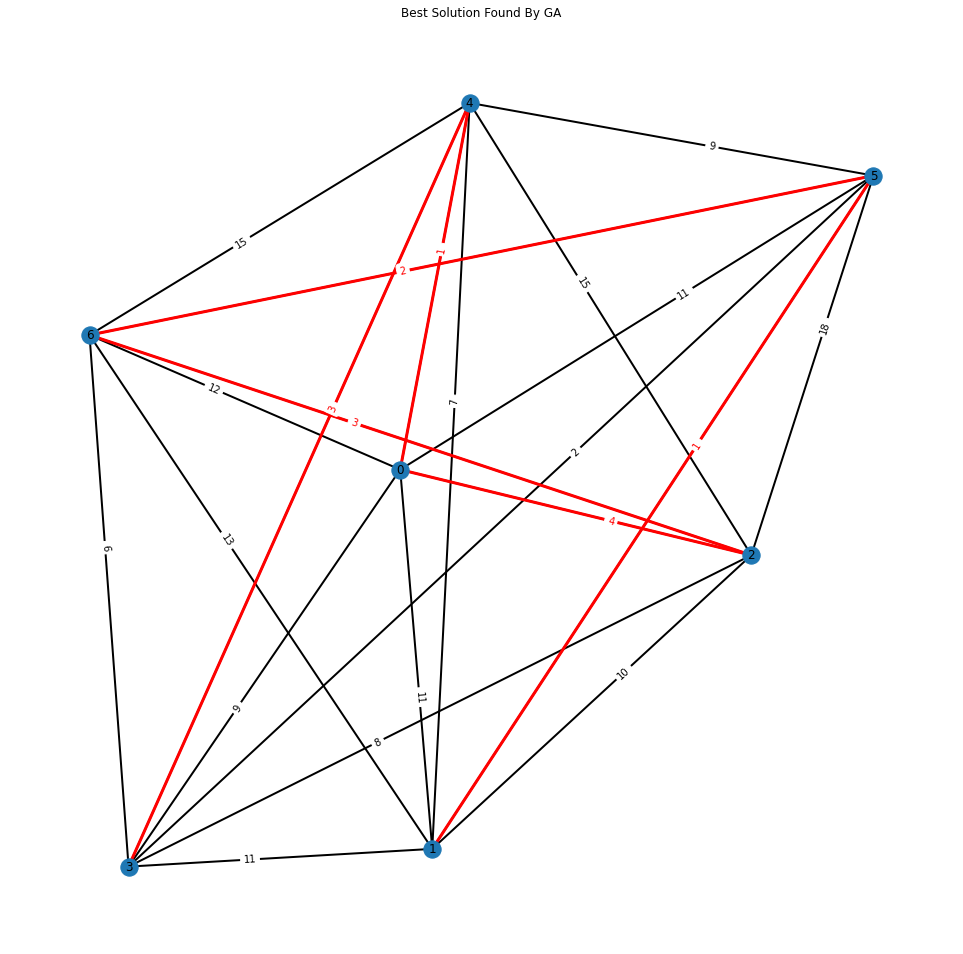

In [276]:
plot_graph(g,"Best Solution Found By GA",nx.path_graph(best).edges)